In [1]:
from datascience import *
path_data = '../../../assets/data/'
import numpy as np
from scipy import stats

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Visual Diagnostics
Suppose a data scientist has decided to use linear regression to estimate values of one variable (called the response variable) based on another variable (called the predictor). To see how well this method of estimation performs, the data scientist must measure how far off the estimates are from the actual values. These differences are called *residuals*.

$$
\mbox{residual} ~=~ \mbox{observed value} ~-~ \mbox{regression estimate}
$$

A residual is what's left over – the residue – after estimation. 

Residuals are the vertical distances of the points from the regression line. There is one residual for each point in the scatter plot. The residual is the difference between the observed value of $y$ and the fitted value of $y$, so for the point $(x, y)$,

$$
\mbox{residual} ~~ = ~~ y ~-~
\mbox{fitted value of }y
~~ = ~~ y ~-~
\mbox{height of regression line at }x
$$

The function `residual` calculates the residuals. The calculation assumes all the relevant functions we have already defined: `standard_units`, `correlation`, `slope`, `intercept`, and `fit`.

In [2]:
galton = Table.read_table(path_data + 'galton.csv')
heights = galton.select('midparentHeight', 'childHeight')
heights = heights.relabel(0, 'MidParent').relabel(1, 'Child')
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [3]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

In [4]:
def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

Continuing our example of using Galton's data to estimate the heights of adult children (the response) based on the midparent height (the predictor), let us calculate the fitted values and the residuals.

In [5]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )
heights

MidParent,Child,Fitted Value,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


When there are so many variables to work with, it is always helpful to start with visualization. The function `scatter_fit` draws the scatter plot of the data, as well as the regression line. 

In [6]:
def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

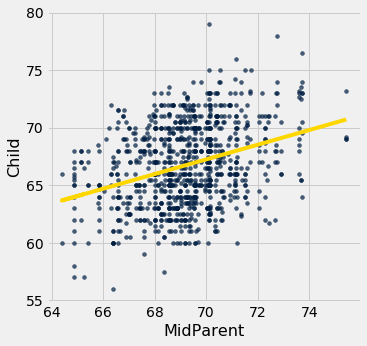

In [7]:
scatter_fit(heights, 'MidParent', 'Child')

A *residual plot* can be drawn by plotting the residuals against the predictor variable. The function `residual_plot` does just that. 

In [8]:
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

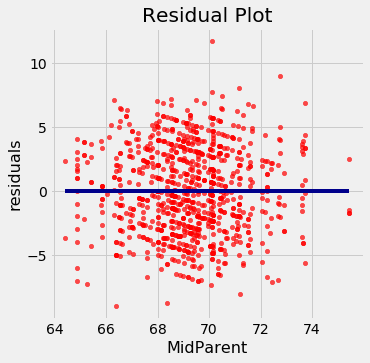

In [9]:
residual_plot(heights, 'MidParent', 'Child')

The midparent heights are on the horizontal axis, as in the original scatter plot. But now the vertical axis shows the residuals. Notice that the plot appears to be centered around the horizontal line at the level 0 (shown in dark blue). Notice also that the plot shows no upward or downward trend. We will observe later that this is true of all regressions.

## Regression Diagnostics
Residual plots help us make visual assessments of the quality of a linear regression analysis. Such assessments are called *diagnostics*. The function ``regression_diagnostic_plots`` draws the original scatter plot as well as the residual plot for ease of comparison.

In [10]:
def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)

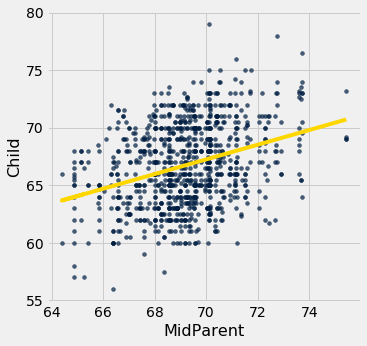

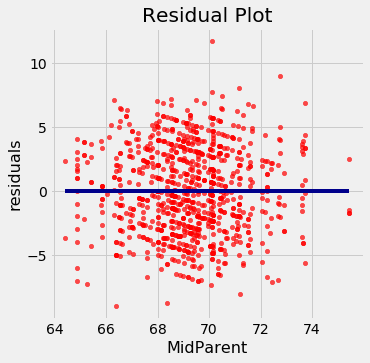

In [11]:
regression_diagnostic_plots(heights, 'MidParent', 'Child')

This residual plot indicates that linear regression was a reasonable method of estimation. Notice how the residuals are distributed fairly symmetrically above and below the horizontal line at 0, corresponding to the original scatter plot being roughly symmetrical above and below. Notice also that the vertical spread of the plot is fairly even across the most common values of the children's heights. In other words, apart from a few outlying points, the plot isn't narrower in some places and wider in others.

In other words, the accuracy of the regression appears to be about the same across the observed range of the predictor variable. 

**The residual plot of a good regression shows no pattern. The residuals look about the same, above and below the horizontal line at 0, across the range of the predictor variable.**

## Detecting Nonlinearity
Drawing the scatter plot of the data usually gives an indication of whether the relation between the two variables is non-linear. Often, however, it is easier to spot non-linearity in a residual plot than in the original scatter plot. This is usually because of the scales of the two plots: the residual plot allows us to zoom in on the errors and hence makes it easier to spot patterns.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/75/Dugong_dugon.jpg"/>

Our data are a [dataset](http://www.statsci.org/data/oz/dugongs.html)  on the age and length of dugongs, which are marine mammals related to manatees and sea cows (image from [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Dugong_dugon.jpg)). The data are in a table called `dugong`. Age is measured in years and length in meters. Because dugongs tend not to keep track of their birthdays, ages are estimated based on variables such as the condition of their teeth.

In [12]:
dugong = Table.read_table(path_data + 'dugongs.csv')
dugong = dugong.move_to_start('Length')
dugong

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5
2.27,4
2.15,5
2.26,5
2.35,7
2.47,8


If we could measure the length of a dugong, what could we say about its age? Let's examine what our data say. Here is a regression of age (the response) on length (the predictor). The correlation between the two variables is substantial, at 0.83.

In [13]:
correlation(dugong, 'Length', 'Age')

0.8296474554905714

High correlation notwithstanding, the plot shows a curved pattern that is much more visible in the residual plot.

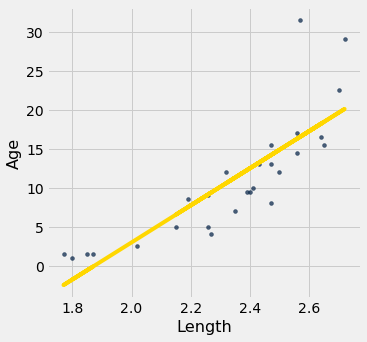

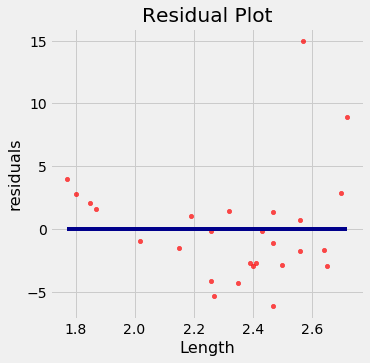

In [14]:
regression_diagnostic_plots(dugong, 'Length', 'Age')

While you can spot the non-linearity in the original scatter, it is more clearly evident in the residual plot.

At the low end of the lengths, the residuals are almost all positive; then they are almost all negative; then positive again at the high end of lengths. In other words the regression estimates have a pattern of being too high, then too low, then too high. That means it would have been better to use a curve instead of a straight line to estimate the ages.

**When a residual plot shows a pattern, there may be a non-linear relation between the variables.**

## Detecting Heteroscedasticity

*Heteroscedasticity* is a word that will surely be of interest to those who are preparing for Spelling Bees. For data scientists, its interest lies in its meaning, which is "uneven spread". 

Recall the table `hybrid` that contains data on hybrid cars in the U.S. Here is a regression of fuel efficiency on the rate of acceleration. The association is negative: cars that accelearate quickly tend to be less efficient.

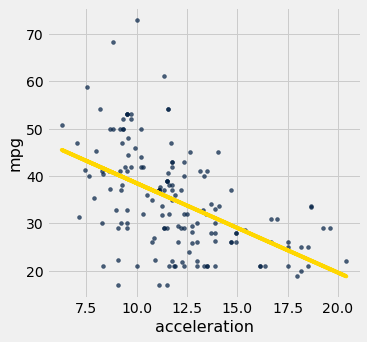

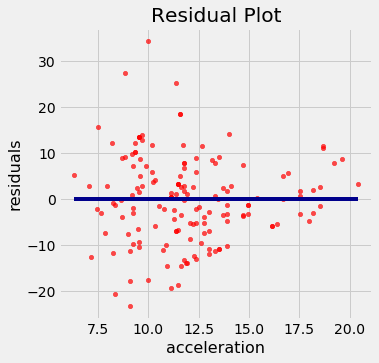

In [15]:
regression_diagnostic_plots(hybrid, 'acceleration', 'mpg')

Notice how the residual plot flares out towards the low end of the accelerations. In other words, the variability in the size of the errors is greater for low values of acceleration than for high values. Uneven variation is often more easily noticed in a residual plot than in the original scatter plot.

**If the residual plot shows uneven variation about the horizontal line at 0, the regression estimates are not equally accurate across the range of the predictor variable.**